# Turkish Earthquake Clustering Analysis

This notebook implements unsupervised learning techniques to identify earthquake patterns and risk zones using our processed AFAD earthquake dataset.

In [214]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
import joblib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point, LineString
import math
import os

# Set visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Load the clean earthquake dataset with original coordinates
earthquake_df = pd.read_csv('produced_data/clean_earthquake_data.csv')

# Load fault line data
fault_gdf = gpd.read_file('data\\tr_faults_imp.geojson')
print(f"Number of fault lines: {len(fault_gdf)}")
print(f"Available properties: {fault_gdf.columns.tolist()}")

# Verify coordinate range
print(f"Dataset shape: {earthquake_df.shape}")
print(f"Coordinate ranges:")
print(f"Longitude: {earthquake_df['Longitude'].min():.2f} to {earthquake_df['Longitude'].max():.2f}")
print(f"Latitude: {earthquake_df['Latitude'].min():.2f} to {earthquake_df['Latitude'].max():.2f}")

earthquake_df.head()

Number of fault lines: 926
Available properties: ['fid', 'RATE', 'CONF', 'SENS1', 'SENS2', 'UPSIDE', 'ZONE_NAME', 'FAULT_NAME', 'AUTH', 'PARM', 'TEXT', 'FAULT_ID', 'importance', 'geometry']
Dataset shape: (9829, 31)
Coordinate ranges:
Longitude: 25.00 to 45.00
Latitude: 35.00 to 42.79


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,...,DistFromPrev,PrevDate,DaysSinceLastQuake,PrevMagnitude,distance_to_fault,nearest_fault_name,nearest_fault_importance,fault_count_50km,fault_length_50km,fault_density
0,1900-01-18 15:30:00,28.21,37.79,10.0,MS,4.4,-,7697,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,NaN,NaN,NaN,NaN,3.911122,Buyuk Menderes Graben South,6,8.0,114.936522,0.014634
1,1900-01-24 03:00:00,26.14,39.54,10.0,MS,5.2,-,7698,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,264.871846,1900-01-18 15:30:00,5.479167,4.4,9.556012,Edremit,4,8.0,89.524527,0.011399
2,1900-01-27 02:30:00,37.37,37.63,10.0,MS,4.8,-,7699,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,998.217752,1900-01-24 03:00:00,2.979167,5.2,1.831552,Turkoglu,1,16.0,203.852282,0.025955
3,1900-01-30 01:00:00,27.71,37.83,10.0,MS,4.4,-,7700,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,849.455702,1900-01-27 02:30:00,2.937500,4.8,5.622901,Buyuk Menderes Graben North,4,8.0,114.936522,0.014634
4,1900-02-06 15:09:00,31.29,38.12,10.0,MS,5.7,-,7701,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,315.428868,1900-01-30 01:00:00,7.589583,4.4,15.331402,"Beysehir Graben West, Beysemia",6,6.0,84.977995,0.010820


## 1. Data Preparation for Clustering

Selecting and preparing relevant features for clustering algorithms.

In [215]:
# If fault features aren't in the data (because we're running this independently of supervised notebook)
# Calculate distance to fault lines
def calc_fault_distance(row, fault_gdf):
    point = Point(row['Longitude'], row['Latitude'])
    
    # Calculate distance to each fault line
    distances = []
    for idx, fault in fault_gdf.iterrows():
        fault_geom = fault.geometry
        dist = point.distance(fault_geom)
        distances.append((dist, idx))
    
    # Find the closest fault
    closest_dist, closest_idx = min(distances, key=lambda x: x[0])
    
    # Convert distance to kilometers (approximation)
    # 1 degree ≈ 111 km at the equator
    dist_km = closest_dist * 111
    
    # Get fault properties
    closest_fault = fault_gdf.iloc[closest_idx]
    
    return pd.Series({
        'distance_to_fault': dist_km,
        'nearest_fault_name': closest_fault.get('FAULT_NAME', 'Unknown'),
        'nearest_fault_importance': closest_fault.get('importance', 0)
    })

# Only calculate if these features don't exist yet
if 'distance_to_fault' not in earthquake_df.columns:
    print("Calculating fault distances...")
    # Process in batches to avoid memory issues
    batch_size = 1000
    all_results = []
    
    for i in range(0, len(earthquake_df), batch_size):
        batch_end = min(i + batch_size, len(earthquake_df))
        print(f"Processing batch {i} to {batch_end}...")
        batch = earthquake_df.iloc[i:batch_end]
        results = batch.apply(lambda row: calc_fault_distance(row, fault_gdf), axis=1)
        all_results.append(results)
    
    fault_features = pd.concat(all_results)
    earthquake_df = pd.concat([earthquake_df, fault_features], axis=1)

# Select features for clustering
# Include geographic features and fault-related features for spatial clustering
clustering_features = ['Longitude', 'Latitude', 'Depth', 'Magnitude']

# Add fault-related features if available
fault_features = ['distance_to_fault', 'nearest_fault_importance']
for feature in fault_features:
    if feature in earthquake_df.columns:
        clustering_features.append(feature)

# Create a subset of data for clustering
cluster_data = earthquake_df[clustering_features].copy()

# Check for missing values
print("Missing values in clustering features:")
print(cluster_data.isnull().sum())

# Fill any missing values if needed
cluster_data.fillna(cluster_data.median(), inplace=True)

# Standardize features for clustering algorithms
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)
scaled_df = pd.DataFrame(scaled_data, columns=clustering_features)

print("Data prepared for clustering:")
scaled_df.describe()

# Create directories if they don't exist
os.makedirs("maps", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("produced_data", exist_ok=True)

print("Created output directories: maps, models, produced_data")

Missing values in clustering features:
Longitude                   0
Latitude                    0
Depth                       0
Magnitude                   0
distance_to_fault           0
nearest_fault_importance    0
dtype: int64
Data prepared for clustering:
Created output directories: maps, models, produced_data


## 2. K-Means Clustering

Using K-Means to identify distinct earthquake zones based on location and characteristics.

K=2, Inertia=45014.32, Silhouette Score=0.264
K=3, Inertia=37861.91, Silhouette Score=0.255
K=4, Inertia=32814.84, Silhouette Score=0.219
K=5, Inertia=28982.28, Silhouette Score=0.234
K=6, Inertia=25693.24, Silhouette Score=0.246
K=7, Inertia=23924.56, Silhouette Score=0.245
K=8, Inertia=22587.68, Silhouette Score=0.232
K=9, Inertia=21171.34, Silhouette Score=0.249
K=10, Inertia=20035.03, Silhouette Score=0.223
K=11, Inertia=19173.31, Silhouette Score=0.247


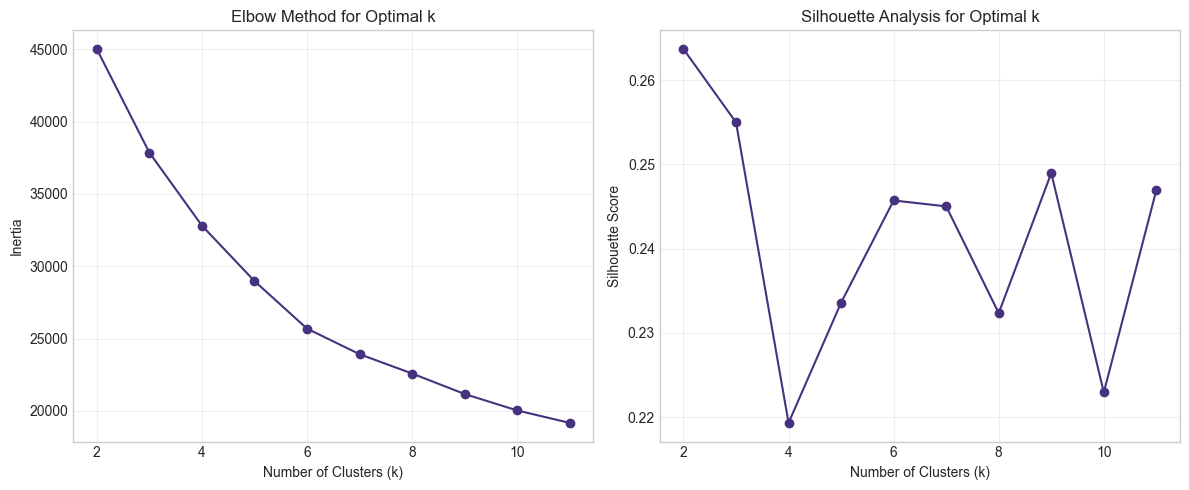

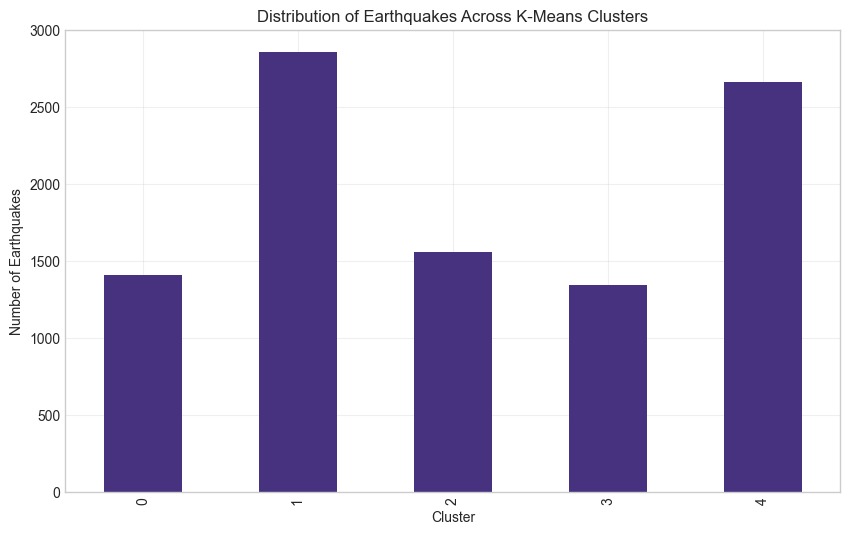

In [216]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 12)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    
    # Compute silhouette score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"K={k}, Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.3f}")

# Plot the Elbow Method results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select the optimal k based on the elbow method and silhouette score
optimal_k = 5  # You should adjust this based on the plots

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original dataframe
earthquake_df['KMeans_Cluster'] = cluster_labels

# Display the distribution of clusters
plt.figure(figsize=(10, 6))
cluster_counts = earthquake_df['KMeans_Cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Earthquakes')
plt.title('Distribution of Earthquakes Across K-Means Clusters')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Visualizing K-Means Clusters

Exploring the geographical and characteristic distribution of the identified clusters.

In [217]:
# Analyze cluster characteristics
cluster_analysis = earthquake_df.groupby('KMeans_Cluster').agg({
    'Longitude': 'mean',
    'Latitude': 'mean',
    'Depth': 'mean',
    'Magnitude': 'mean',
    'KMeans_Cluster': 'count'
}).rename(columns={'KMeans_Cluster': 'Count'})

# Add fault distance stats if available
if 'distance_to_fault' in earthquake_df.columns:
    fault_stats = earthquake_df.groupby('KMeans_Cluster').agg({
        'distance_to_fault': ['mean', 'min'],
        'nearest_fault_importance': 'mean'
    })
    
    # Flatten MultiIndex columns
    fault_stats.columns = ['_'.join(col).strip() for col in fault_stats.columns.values]
    cluster_analysis = pd.concat([cluster_analysis, fault_stats], axis=1)

print("Cluster characteristics:")
print(cluster_analysis)

# Create K-means map visualization with folium - FIXED coordinates
kmeans_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

# Create a discrete color map for clusters
cluster_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'cadetblue']

# Add clusters as markers, ensuring coordinates are within Turkey's boundaries
for idx, row in earthquake_df.sample(min(5000, len(earthquake_df))).iterrows():
    cluster_idx = int(row['KMeans_Cluster']) % len(cluster_colors)
    color = cluster_colors[cluster_idx]
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],  # Latitude first, Longitude second
        radius=3 + (row['Magnitude'] - 4)/2,  # Size based on magnitude
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {row['KMeans_Cluster']}<br>Magnitude: {row['Magnitude']}"
    ).add_to(kmeans_map)

# Add cluster centers as larger markers
for cluster_id, group in earthquake_df.groupby('KMeans_Cluster'):
    center_lat = group['Latitude'].mean()
    center_lon = group['Longitude'].mean()
    cluster_idx = int(cluster_id) % len(cluster_colors)
    color = cluster_colors[cluster_idx]
    
    folium.CircleMarker(
        location=[center_lat, center_lon],  # Latitude first, Longitude second
        radius=8,
        color='black',
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"Cluster Center {cluster_id}"
    ).add_to(kmeans_map)

# Add fault lines to the map
def add_faults_to_map(map_obj, fault_gdf, importance_threshold=0):
    # Filter faults by importance if desired
    if importance_threshold > 0:
        fault_data = fault_gdf[fault_gdf['importance'] >= importance_threshold]
    else:
        fault_data = fault_gdf
    
    # Color by importance
    def style_function(feature):
        importance = feature['properties']['importance']
        color = '#FF0000' if importance >= 4 else '#FFA500' if importance >= 3 else '#FFFF00'
        return {
            'color': color,
            'weight': importance * 0.5,  # Thicker lines for more important faults
            'opacity': 0.7
        }
    
    # Add GeoJSON to map
    folium.GeoJson(
        fault_data,
        name='Fault Lines',
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['FAULT_NAME', 'importance']),
    ).add_to(map_obj)
    
    return map_obj

# Add fault lines to the map
kmeans_map = add_faults_to_map(kmeans_map, fault_gdf, importance_threshold=3)

# Add better tile layer
folium.TileLayer('cartodbpositron').add_to(kmeans_map)

# Add layer control
folium.LayerControl().add_to(kmeans_map)

# For K-means map - adding clearer legend
kmeans_legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 200px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    padding: 10px; border-radius: 5px; font-family: Arial;">
    <h4 style="margin-top:0;">K-Means Clusters</h4>
    
    <div style="margin-top:5px;">
      <p><b>Cluster Colors:</b></p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: red; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 0</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: blue; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 1</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: green; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 2</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: purple; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 3</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: orange; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 4</span>
      </div>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Marker Size:</b> Proportional to earthquake magnitude</p>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Fault Line Importance:</b></p>
      <p><span style="color:#FF0000;">━━━</span> High (4+)</p>
      <p><span style="color:#FFA500;">━━━</span> Medium (3)</p>
      <p><span style="color:#FFFF00;">━━━</span> Low (<3)</p>
    </div>
</div>
'''
kmeans_map.get_root().html.add_child(folium.Element(kmeans_legend_html))

# Save the map
kmeans_map.save('maps/kmeans_clusters_map.html')
print("K-means cluster map saved as 'maps/kmeans_clusters_map.html'")

# Also create a Plotly version for the notebook 
fig_kmeans = px.scatter_mapbox(
    earthquake_df.sample(min(3000, len(earthquake_df))), 
    lat='Latitude',  # Ensure correct parameter for latitude 
    lon='Longitude',  # Ensure correct parameter for longitude
    color='KMeans_Cluster',
    size='Magnitude',
    color_continuous_scale=px.colors.qualitative.Bold,
    size_max=15,
    zoom=5,
    center={"lat": 38.5, "lon": 35.5},  # Centered on Turkey
    mapbox_style="open-street-map",
    title='K-Means Clusters of Turkish Earthquakes',
    hover_data=['Depth', 'Magnitude', 'KMeans_Cluster']
)
fig_kmeans.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_kmeans.write_html('maps/kmeans_clusters_map_plotly.html')

Cluster characteristics:
                Longitude   Latitude      Depth  Magnitude  Count  \
KMeans_Cluster                                                      
0               29.681750  36.752550  51.333862   4.597653   1406   
1               28.764406  38.586180  13.420133   4.380476   2858   
2               32.540850  38.967310  15.760807   4.486483   1561   
3               27.968495  35.803784  19.784154   4.362789   1341   
4               40.676509  39.199156  13.751341   4.454112   2663   

                distance_to_fault_mean  distance_to_fault_min  \
KMeans_Cluster                                                  
0                            56.264959               0.003352   
1                            21.544112               0.001776   
2                            14.466071               0.003379   
3                           146.383562              54.046748   
4                            23.168106               0.002047   

                nearest_fault_impor

## 4. DBSCAN Clustering

Using DBSCAN to identify dense clusters and potential outliers in earthquake data.

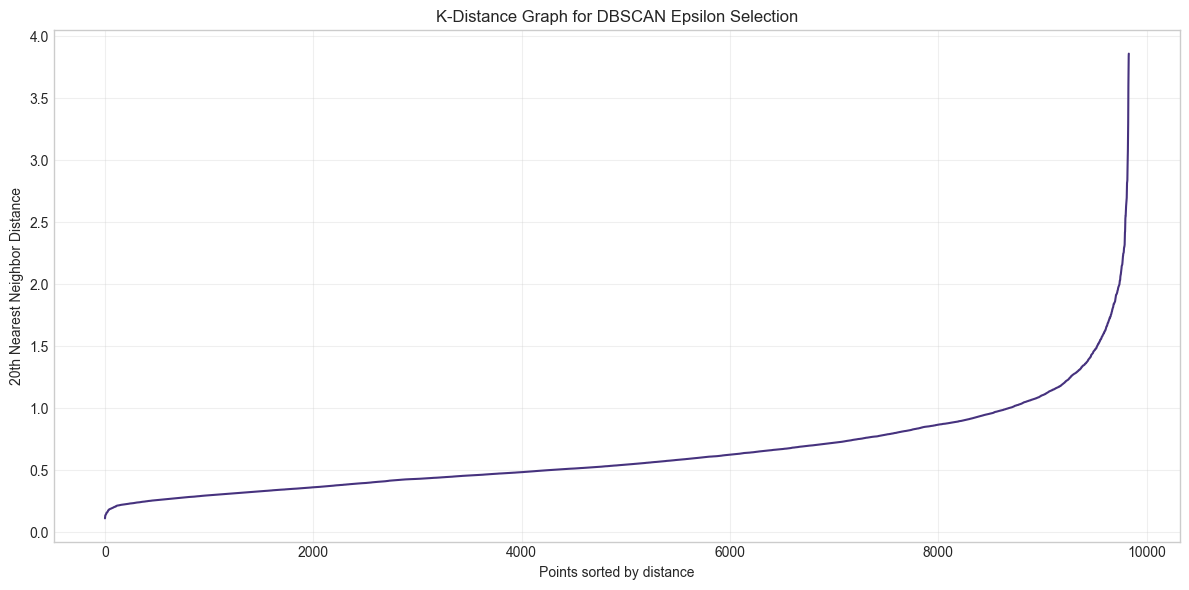

DBSCAN found 14 clusters and 3826 noise points.
Percentage of noise points: 38.93%


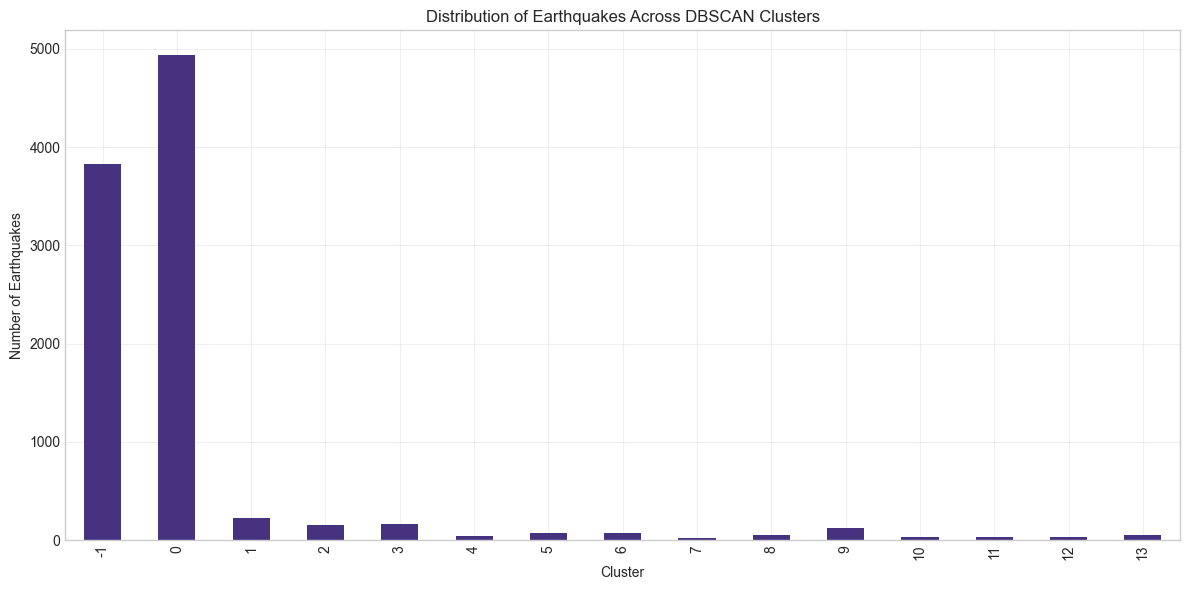

In [218]:
# Apply DBSCAN clustering
# We need to find appropriate epsilon and min_samples values
from sklearn.neighbors import NearestNeighbors

# Determine epsilon using k-distance graph
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort distances for k-distance graph
distances = np.sort(distances, axis=0)
distances = distances[:, 19]  # 20th neighbor

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('20th Nearest Neighbor Distance')
plt.title('K-Distance Graph for DBSCAN Epsilon Selection')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Based on the k-distance plot, choose an appropriate epsilon
# Look for the "elbow" in the plot
epsilon = 0.5  # Adjust based on the plot
min_samples = 20  # Minimum neighbors for a core point

# Apply DBSCAN with chosen parameters
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Add DBSCAN labels to the dataframe
earthquake_df['DBSCAN_Cluster'] = dbscan_labels

# Count the number of clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")
print(f"Percentage of noise points: {n_noise / len(dbscan_labels) * 100:.2f}%")

# Display the distribution of DBSCAN clusters
plt.figure(figsize=(12, 6))
cluster_counts = earthquake_df['DBSCAN_Cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Earthquakes')
plt.title('Distribution of Earthquakes Across DBSCAN Clusters')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Visualizing DBSCAN Clusters

Mapping the DBSCAN clusters to identify high-density earthquake zones and outliers.

In [219]:
# Create DBSCAN map visualization with folium
dbscan_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

# Number of clusters excluding noise
num_clusters = len(set(earthquake_df['DBSCAN_Cluster'])) - (1 if -1 in earthquake_df['DBSCAN_Cluster'].values else 0)
colormap = cm.get_cmap('tab20', max(num_clusters + 1, 2))  # +1 for noise points

# Function to get color for cluster
def get_cluster_color(cluster_id):
    if cluster_id == -1:  # Noise points
        return '#000000'  # Black
    else:
        rgba = colormap(cluster_id % max(num_clusters, 1))
        return mcolors.rgb2hex(rgba)

# Add data points with proper colors (sample for performance)
for idx, row in earthquake_df.sample(min(5000, len(earthquake_df))).iterrows():
    cluster_id = int(row['DBSCAN_Cluster'])
    color = get_cluster_color(cluster_id)
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],  # Latitude first, then Longitude
        radius=3 + (row['Magnitude'] - 4)/2,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7 if cluster_id != -1 else 0.3,  # Make noise points more transparent
        popup=f"Cluster: {cluster_id}<br>Magnitude: {row['Magnitude']}"
    ).add_to(dbscan_map)

# Add fault lines to the map
dbscan_map = add_faults_to_map(dbscan_map, fault_gdf, importance_threshold=3)

# Add better tile layer
folium.TileLayer('cartodbpositron').add_to(dbscan_map)

# Add layer control
folium.LayerControl().add_to(dbscan_map)

# For DBSCAN map - adding clearer legend
dbscan_legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 200px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    padding: 10px; border-radius: 5px; font-family: Arial;">
    <h4 style="margin-top:0;">DBSCAN Clusters</h4>
    
    <div style="margin-top:5px;">
      <p><b>Cluster Colors:</b> Each color represents a distinct spatial cluster</p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: black; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%; opacity: 0.3;"></div>
        <span>Noise points (-1)</span>
      </div>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Marker Size:</b> Proportional to earthquake magnitude</p>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Fault Line Importance:</b></p>
      <p><span style="color:#FF0000;">━━━</span> High (4+)</p>
      <p><span style="color:#FFA500;">━━━</span> Medium (3)</p>
      <p><span style="color:#FFFF00;">━━━</span> Low (<3)</p>
    </div>
</div>
'''
dbscan_map.get_root().html.add_child(folium.Element(dbscan_legend_html))

# Save the map
dbscan_map.save('maps/dbscan_clusters_map.html')
print("DBSCAN cluster map saved as 'maps/dbscan_clusters_map.html'")

# Also create a Plotly version for the notebook
fig_dbscan = px.scatter_mapbox(
    earthquake_df.sample(min(3000, len(earthquake_df))), 
    lat='Latitude',  # Correct parameter for latitude
    lon='Longitude',  # Correct parameter for longitude
    color='DBSCAN_Cluster',
    size='Magnitude',
    color_continuous_scale=px.colors.qualitative.Dark24,
    size_max=15,
    zoom=5,
    center={"lat": 38.5, "lon": 35.5},  # Centered on Turkey
    mapbox_style="open-street-map",
    title='DBSCAN Clusters of Turkish Earthquakes',
    hover_data=['Depth', 'Magnitude', 'DBSCAN_Cluster']
)
fig_dbscan.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_dbscan.write_html('maps/dbscan_clusters_map_plotly.html')

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_26500\1726746352.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



DBSCAN cluster map saved as 'maps/dbscan_clusters_map.html'


In [220]:
# Create density heatmap with Plotly
fig_density = px.density_mapbox(
    earthquake_df, 
    lat='Latitude',  # Correct parameter for latitude
    lon='Longitude',  # Correct parameter for longitude
    z='Magnitude',
    radius=10,
    zoom=5, 
    center={"lat": 38.5, "lon": 35.5},  # Centered on Turkey
    mapbox_style="open-street-map",
    title='Earthquake Density Heatmap'
)
fig_density.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_density.write_html('maps/earthquake_density_map.html')

# Analyze DBSCAN cluster characteristics
dbscan_analysis = earthquake_df[earthquake_df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster').agg({
    'Longitude': 'mean',
    'Latitude': 'mean',
    'Depth': 'mean',
    'Magnitude': 'mean',
    'DBSCAN_Cluster': 'count'
}).rename(columns={'DBSCAN_Cluster': 'Count'})

# Add fault distance stats if available
if 'distance_to_fault' in earthquake_df.columns:
    fault_stats_dbscan = earthquake_df[earthquake_df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster').agg({
        'distance_to_fault': ['mean', 'min'],
        'nearest_fault_importance': 'mean'
    })
    
    # Flatten MultiIndex columns
    fault_stats_dbscan.columns = ['_'.join(col).strip() for col in fault_stats_dbscan.columns.values]
    dbscan_analysis = pd.concat([dbscan_analysis, fault_stats_dbscan], axis=1)

print("DBSCAN cluster characteristics (excluding noise):")
print(dbscan_analysis)

# Noise point characteristics
noise_points = earthquake_df[earthquake_df['DBSCAN_Cluster'] == -1]
print("\nNoise point characteristics:")
print(noise_points[['Longitude', 'Latitude', 'Depth', 'Magnitude']].describe())

# Calculate average distance to fault for noise points if available
if 'distance_to_fault' in earthquake_df.columns:
    print("\nNoise points fault distance statistics:")
    print(noise_points[['distance_to_fault', 'nearest_fault_importance']].describe())

DBSCAN cluster characteristics (excluding noise):
                Longitude   Latitude      Depth  Magnitude  Count  \
DBSCAN_Cluster                                                      
0               31.501174  37.878979  16.773979   4.295183   4941   
1               27.914080  39.314799   9.365247   4.148879    223   
2               39.193661  38.289184   8.888129   4.202581    155   
3               43.527623  42.499838   9.839207   4.302439    164   
4               31.258191  36.055167  59.935870   4.232609     46   
5               29.030301  40.642986   8.502464   4.156522     69   
6               38.321630  38.047958   8.506232   4.240580     69   
7               42.140138  40.346081  34.114286   4.604762     21   
8               38.254742  37.990031   8.088654   4.132692     52   
9               37.862972  37.881304   8.736885   4.267213    122   
10              28.078815  36.917815  10.119091   4.166667     33   
11              33.887653  40.752200   8.693333   4.0

In [221]:
# Create a 3D scatter plot of DBSCAN clusters with fault information if available
if 'distance_to_fault' in earthquake_df.columns:
    fig = px.scatter_3d(
        earthquake_df.sample(min(5000, len(earthquake_df))), 
        x='Longitude', 
        y='Latitude', 
        z='Depth',
        color='DBSCAN_Cluster', 
        size='Magnitude',
        color_continuous_scale=px.colors.qualitative.G10,
        hover_data=['distance_to_fault', 'nearest_fault_importance'],
        title='3D Visualization of DBSCAN Earthquake Clusters with Fault Information'
    )
else:
    fig = px.scatter_3d(
        earthquake_df.sample(min(5000, len(earthquake_df))), 
        x='Longitude', 
        y='Latitude', 
        z='Depth',
        color='DBSCAN_Cluster', 
        size='Magnitude',
        color_continuous_scale=px.colors.qualitative.G10,
        title='3D Visualization of DBSCAN Earthquake Clusters'
    )
# Ensure proper axis orientation and labels
fig.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Depth (km)',
    zaxis=dict(autorange="reversed")  # Reverse depth axis so deeper is lower
))
fig.write_html('maps/dbscan_clusters_3d.html')

## 6. Dimensionality Reduction with PCA

Using PCA to visualize high-dimensional earthquake data in 2D space.

Explained variance ratio:
[0.33406184 0.18482242]
Total explained variance: 51.89%


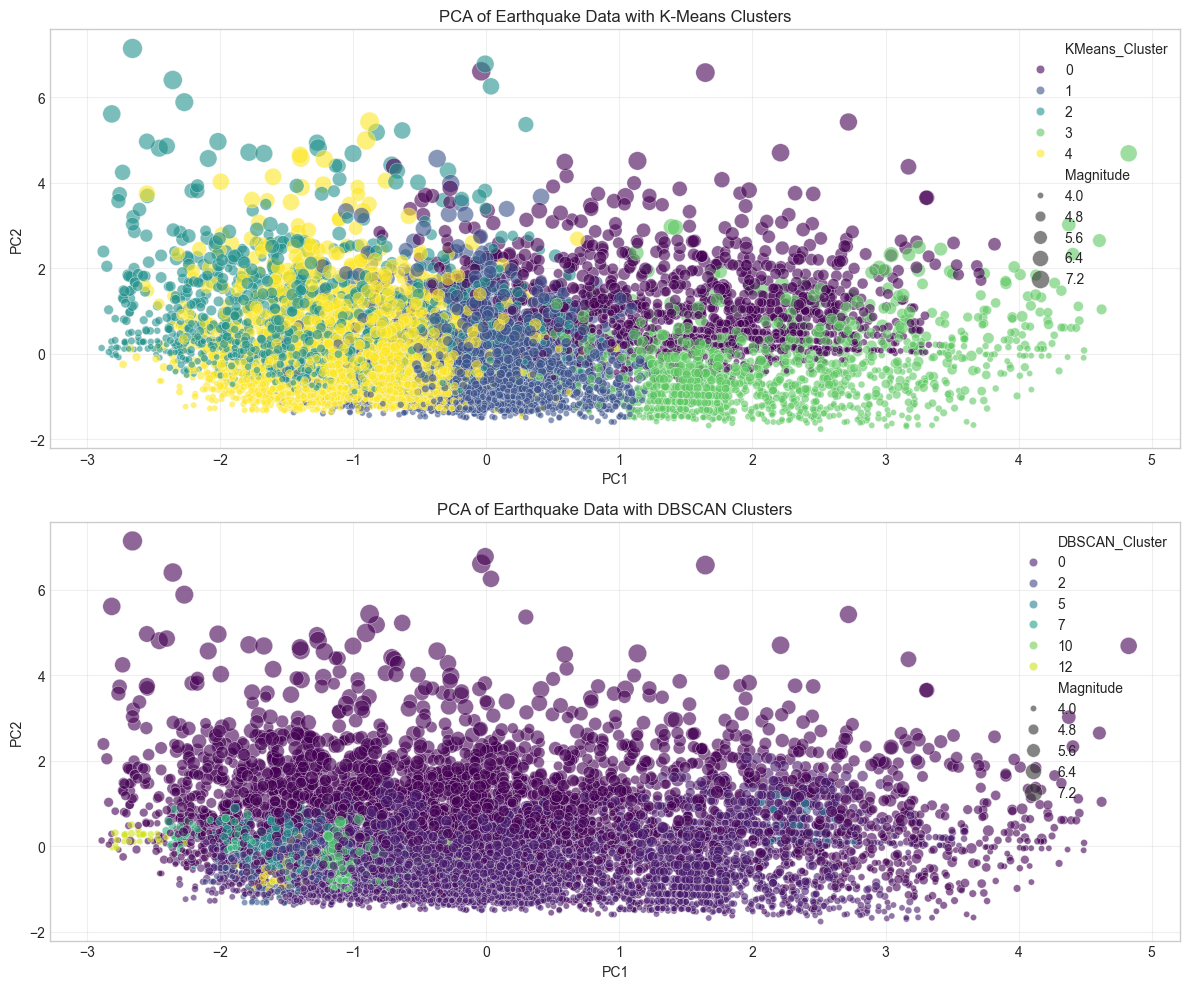

In [222]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['KMeans_Cluster'] = earthquake_df['KMeans_Cluster']
pca_df['DBSCAN_Cluster'] = earthquake_df['DBSCAN_Cluster']
pca_df['Magnitude'] = earthquake_df['Magnitude']

# Add fault distance if available
if 'distance_to_fault' in earthquake_df.columns:
    pca_df['distance_to_fault'] = earthquake_df['distance_to_fault']
    pca_df['nearest_fault_importance'] = earthquake_df['nearest_fault_importance']

# Explained variance ratio
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)
print(f"Total explained variance: {sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Visualize PCA results with K-Means clusters
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='KMeans_Cluster', palette='viridis', 
                size='Magnitude', sizes=(20, 200), alpha=0.6)
plt.title('PCA of Earthquake Data with K-Means Clusters')
plt.grid(True, alpha=0.3)

# Visualize PCA results with DBSCAN clusters
plt.subplot(2, 1, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='DBSCAN_Cluster', palette='viridis', 
                size='Magnitude', sizes=(20, 200), alpha=0.6)
plt.title('PCA of Earthquake Data with DBSCAN Clusters')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


PCA Feature Loadings:
                               PC1       PC2
Longitude                -0.435980  0.060213
Latitude                 -0.557317  0.038688
Depth                     0.364064  0.502461
Magnitude                -0.022175  0.812045
distance_to_fault         0.521458 -0.058389
nearest_fault_importance  0.307191 -0.282106


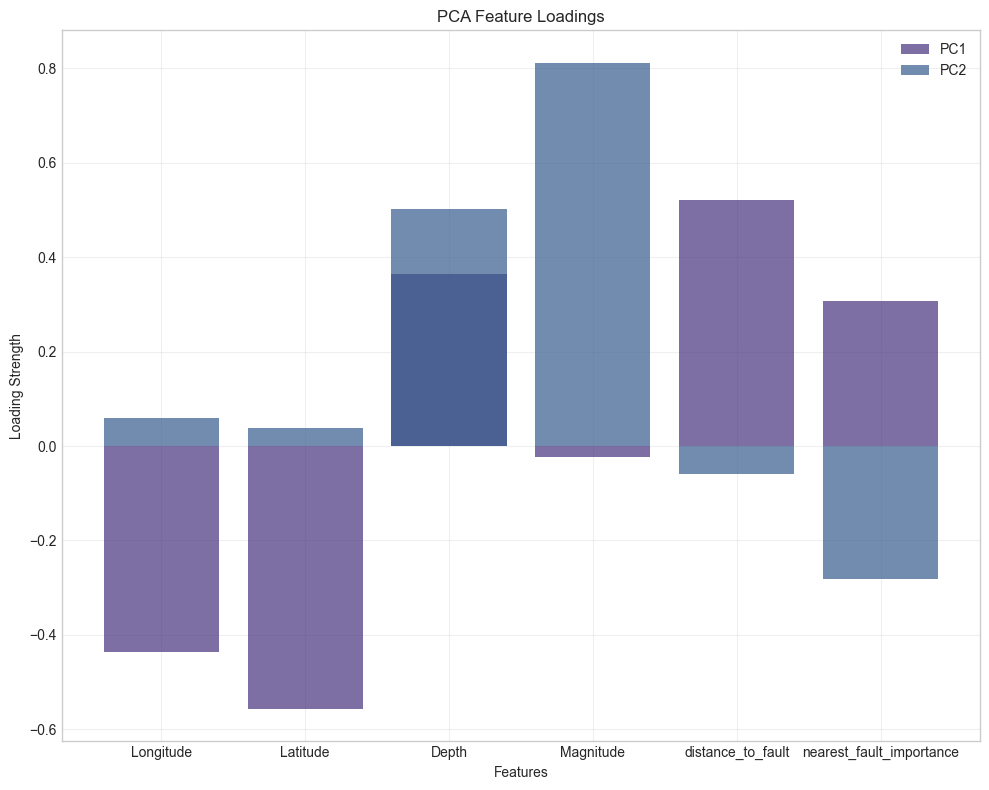

In [223]:
# Feature loadings on principal components
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'],
    index=clustering_features
)

print("\nPCA Feature Loadings:")
print(loadings)

# Visualize the feature loadings
plt.figure(figsize=(10, 8))
plt.bar(loadings.index, loadings['PC1'], alpha=0.7, label='PC1')
plt.bar(loadings.index, loadings['PC2'], alpha=0.7, label='PC2')
plt.xlabel('Features')
plt.ylabel('Loading Strength')
plt.title('PCA Feature Loadings')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Risk Zone Identification

Using clustering results to identify high-risk earthquake zones.

Adding fault-based risk factors...
Risk Zone Distribution:
Risk_Zone
Medium    6501
Low       3157
High       171
Name: count, dtype: int64


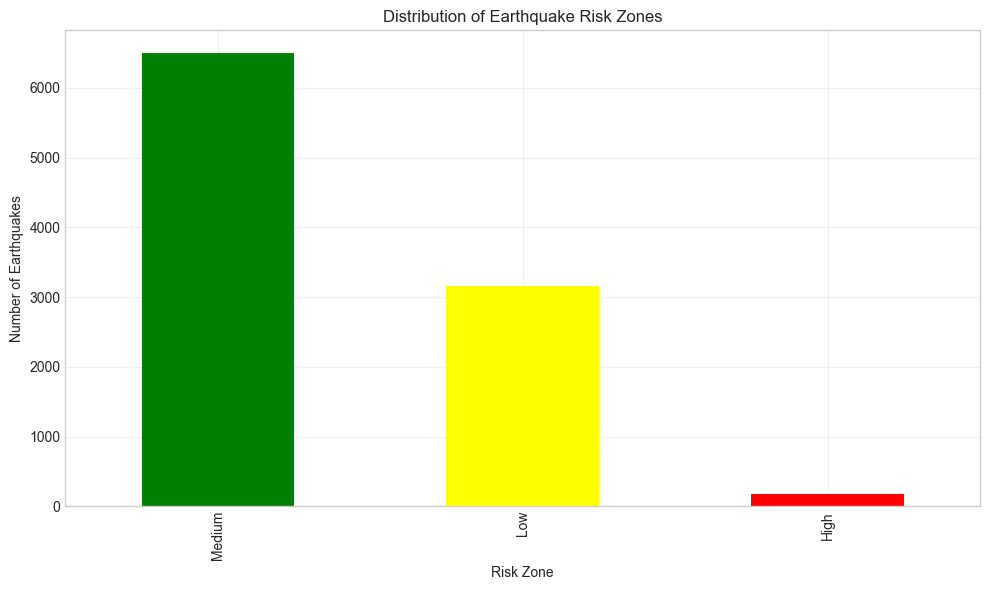

In [224]:
# Combine clustering information with magnitude to identify risk zones
earthquake_df['Risk_Score'] = 0

# Calculate risk score based on:
# 1. Magnitude
# 2. Cluster density
# 3. Fault data (if available)

# Scale magnitude to 0-10 range (assuming most are between 4-8)
earthquake_df['Magnitude_Score'] = (earthquake_df['Magnitude'] - 4) * 2.5
earthquake_df['Magnitude_Score'] = earthquake_df['Magnitude_Score'].clip(0, 10)

# Calculate density of clusters (earthquakes per area)
# First, verify we have valid coordinate ranges to avoid division by zero
kmeans_spatial_range = earthquake_df.groupby('KMeans_Cluster').agg({
    'Longitude': lambda x: max(x) - min(x),
    'Latitude': lambda x: max(x) - min(x)
})

# Ensure we don't divide by zero by adding a small value
kmeans_spatial_range = kmeans_spatial_range + 0.001  # Add small value to prevent division by zero

# Now calculate density safely
kmeans_density = earthquake_df.groupby('KMeans_Cluster').size() / kmeans_spatial_range.prod(axis=1)

# Normalize density to 0-10 scale
max_density = kmeans_density.max()
if max_density > 0:  # Avoid division by zero
    normalized_density = (kmeans_density / max_density) * 10
else:
    normalized_density = kmeans_density * 0  # All zeros if max_density is 0

# Map density scores back to dataframe
density_map = dict(zip(normalized_density.index, normalized_density.values))
earthquake_df['Density_Score'] = earthquake_df['KMeans_Cluster'].map(density_map)

# Add fault-based risk if features available
if 'distance_to_fault' in earthquake_df.columns and 'nearest_fault_importance' in earthquake_df.columns:
    print("Adding fault-based risk factors...")
    
    # Inverse distance to fault (closer = higher risk)
    earthquake_df['Fault_Distance_Score'] = 10 / (earthquake_df['distance_to_fault'] + 1)
    
    # Scale by fault importance
    earthquake_df['Fault_Importance_Score'] = earthquake_df['nearest_fault_importance'] * 2
    
    # Calculate final risk score with fault information
    earthquake_df['Risk_Score'] = (
        earthquake_df['Magnitude_Score'] * 0.4 + 
        earthquake_df['Density_Score'] * 0.3 +
        earthquake_df['Fault_Distance_Score'] * 0.2 +
        earthquake_df['Fault_Importance_Score'] * 0.1
    )
else:
    # Calculate risk score without fault data
    earthquake_df['Risk_Score'] = (
        earthquake_df['Magnitude_Score'] * 0.6 + 
        earthquake_df['Density_Score'] * 0.4
    )

# Classify risk zones
earthquake_df['Risk_Zone'] = pd.cut(
    earthquake_df['Risk_Score'], 
    bins=[0, 3, 6, 10], 
    labels=['Low', 'Medium', 'High']
)

# Display risk zone distribution
risk_distribution = earthquake_df['Risk_Zone'].value_counts()
print("Risk Zone Distribution:")
print(risk_distribution)

plt.figure(figsize=(10, 6))
risk_distribution.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Distribution of Earthquake Risk Zones')
plt.xlabel('Risk Zone')
plt.ylabel('Number of Earthquakes')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [225]:
# Create a risk zone map with folium
risk_map = folium.Map(location=[38.5, 35.5], zoom_start=6, tiles="cartodbpositron")

# Color mapping for risk zones
risk_colors = {
    'Low': 'green',
    'Medium': 'orange',
    'High': 'red'
}

# Color mapping for magnitude ranges
magnitude_colors = {
    'Minor (4-5)': '#fee5d9',
    'Moderate (5-6)': '#fcbba1',
    'Strong (6-7)': '#fc9272',
    'Major (7-8)': '#fb6a4a',
    'Great (8+)': '#de2d26'
}

# Create separate marker clusters for better performance
marker_clusters = {
    'Low': folium.plugins.MarkerCluster(name='Low Risk').add_to(risk_map),
    'Medium': folium.plugins.MarkerCluster(name='Medium Risk').add_to(risk_map),
    'High': folium.plugins.MarkerCluster(name='High Risk').add_to(risk_map)
}

# Function to get magnitude category and color
def get_magnitude_info(magnitude):
    if magnitude >= 8:
        return 'Great (8+)', magnitude_colors['Great (8+)']
    elif magnitude >= 7:
        return 'Major (7-8)', magnitude_colors['Major (7-8)']
    elif magnitude >= 6:
        return 'Strong (6-7)', magnitude_colors['Strong (6-7)']
    elif magnitude >= 5:
        return 'Moderate (5-6)', magnitude_colors['Moderate (5-6)']
    else:
        return 'Minor (4-5)', magnitude_colors['Minor (4-5)']

# Add markers for ALL earthquakes
for idx, row in earthquake_df.iterrows():
    risk_zone = row['Risk_Zone']
    magnitude = row['Magnitude']
    mag_category, mag_color = get_magnitude_info(magnitude)
    
    # Enhanced exponential radius calculation with greater emphasis on large earthquakes
    if magnitude >= 7:
        # Much more exponential growth for major earthquakes
        radius = 15 + ((magnitude - 7) ** 2) * 6
    else:
        radius = 3 + (magnitude - 4) ** 1.5  # Exponential growth
        
    popup_content = f"""
    <div style="font-family: Arial; min-width: 180px;">
        <h4 style="margin-bottom: 5px;">Earthquake Details</h4>
        <b>Magnitude:</b> {magnitude:.1f} ({mag_category})<br>
        <b>Risk Zone:</b> {risk_zone}<br>
        <b>Risk Score:</b> {row['Risk_Score']:.2f}<br>
        <b>Depth:</b> {row['Depth']:.1f} km<br>
    """
    
    # Add date if available
    if 'Date' in row:
        popup_content += f"<b>Date:</b> {row['Date']}<br>"
        
    # Add location if available
    if 'Location' in row:
        popup_content += f"<b>Location:</b> {row['Location']}<br>"
        
    # Add fault information if available
    if 'distance_to_fault' in row and 'nearest_fault_name' in row:
        popup_content += f"<b>Nearest Fault:</b> {row['nearest_fault_name']}<br>"
        popup_content += f"<b>Distance to Fault:</b> {row['distance_to_fault']:.2f} km<br>"
    
    popup_content += "</div>"
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=radius,
        color=risk_colors[risk_zone],  # Border color shows risk zone
        weight=2,  # Thicker border
        fill=True,
        fill_color=mag_color,  # Fill color shows magnitude
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(marker_clusters[risk_zone])

# Add fault lines to the map
risk_map = add_faults_to_map(risk_map, fault_gdf, importance_threshold=3)

# Add additional tile layers for users to choose
folium.TileLayer('Stamen Toner', name='High Contrast').add_to(risk_map)
folium.TileLayer('cartodbpositron', name='Light').add_to(risk_map)
folium.TileLayer('OpenStreetMap', name='Detailed').add_to(risk_map)

# Enhance risk zone map legend
risk_legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 250px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    padding: 10px; border-radius: 5px; font-family: Arial;">
    <h4 style="margin-top:0;">Earthquake Risk Zones</h4>
    
    <div style="margin-top:5px;">
      <p><b>Border Color:</b> Risk Zone</p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: green; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Low Risk</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: orange; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Medium Risk</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: red; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>High Risk</span>
      </div>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Fill Color:</b> Magnitude</p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #fee5d9; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Minor (4-5)</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #fcbba1; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Moderate (5-6)</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #fc9272; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Strong (6-7)</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #fb6a4a; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Major (7-8)</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #de2d26; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Great (8+)</span>
      </div>
    </div>
    
    <div style="margin-top:5px;">
      <p><b>Marker Size:</b> Proportional to magnitude</p>
    </div>
</div>
'''
risk_map.get_root().html.add_child(folium.Element(risk_legend_html))

# Add layer control
folium.LayerControl().add_to(risk_map)

# Save risk map to HTML file
risk_map.save('maps/earthquake_risk_map.html')
print("Enhanced earthquake risk map saved as 'maps/earthquake_risk_map.html'")

Enhanced earthquake risk map saved as 'maps/earthquake_risk_map.html'


### 8. Risk Assessment for Population Centers

City Earthquake Risk Assessment:
                             city  population  earthquake_count  \
0                        Istanbul    15655924                46   
2                           Izmir     4479525               147   
17                            Van     1127612               273   
20                        Sakarya     1100747               173   
3                           Bursa     3214571                85   
25                        Malatya      742725               267   
11                          Hatay     1544640                88   
16                  Kahramanmaraş     1116618               160   
12                         Manisa     1475716               117   
4                         Antalya     2696249                61   
22                          Muğla     1066736               110   
15                      Balıkesir     1273519                99   
19                        Denizli     1061043               121   
7                       Gazia

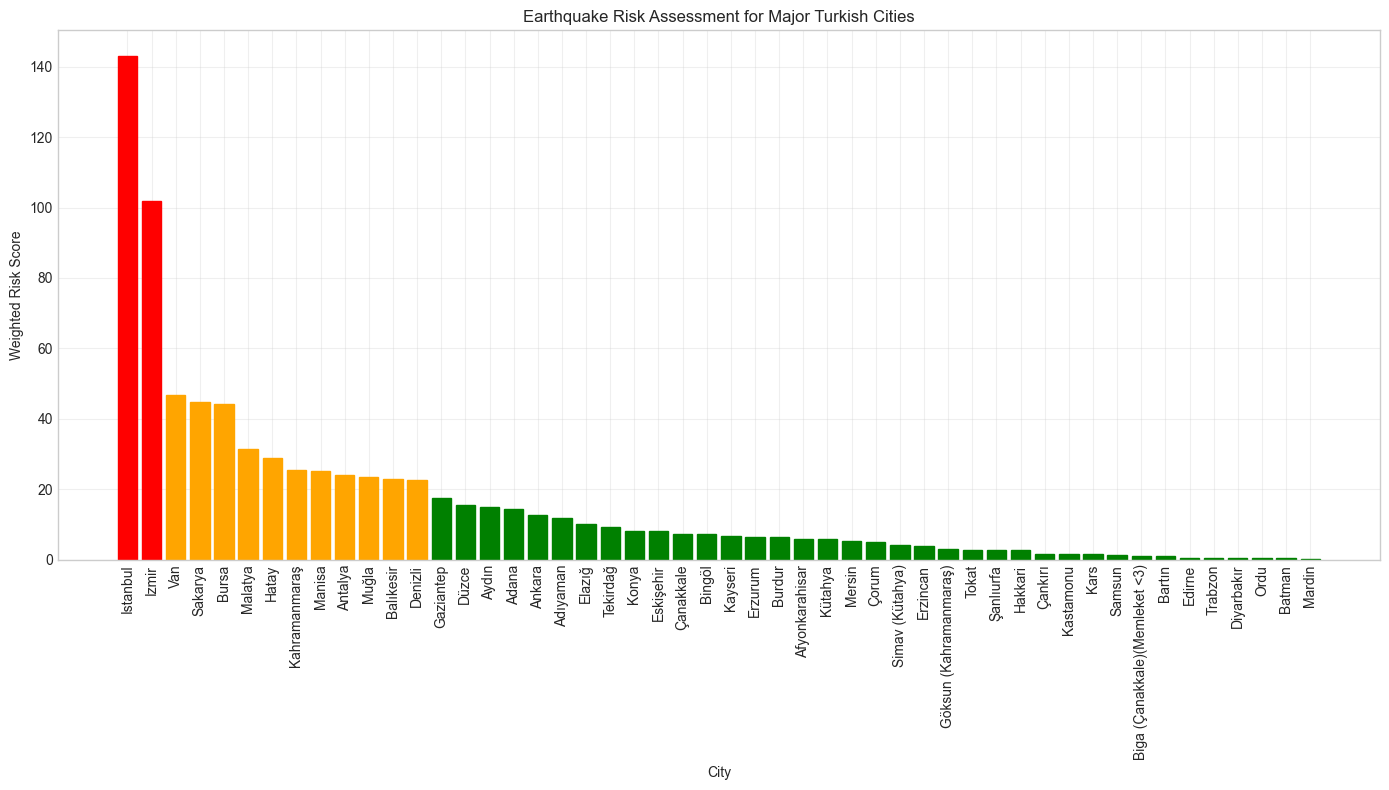

In [ ]:
# Create a list of major Turkish cities for risk assessment
cities = [
    {"name": "Istanbul", "lat": 41.0082, "lon": 28.9784, "population": 15655924},
    {"name": "Ankara", "lat": 39.9334, "lon": 32.8597, "population": 5803482},
    {"name": "Izmir", "lat": 38.4237, "lon": 27.1428, "population": 4479525},
    {"name": "Bursa", "lat": 40.1885, "lon": 29.0610, "population": 3214571},
    {"name": "Antalya", "lat": 36.8969, "lon": 30.7133, "population": 2696249},
    {"name": "Adana", "lat": 37.0000, "lon": 35.3213, "population": 2270298},
    {"name": "Konya", "lat": 37.8667, "lon": 32.4833, "population": 2320241},
    {"name": "Gaziantep", "lat": 37.0662, "lon": 37.3833, "population": 2164134},
    {"name": "Şanlıurfa", "lat": 37.1591, "lon": 38.7969, "population": 2213964},
    {"name": "Mersin", "lat": 36.8000, "lon": 34.6333, "population": 1938389},
    {"name": "Diyarbakır", "lat": 37.9144, "lon": 40.2306, "population": 1818133},
    {"name": "Hatay", "lat": 36.2025, "lon": 36.1606, "population": 1544640},
    {"name": "Manisa", "lat": 38.6191, "lon": 27.4289, "population": 1475716},
    {"name": "Kayseri", "lat": 38.7205, "lon": 35.4826, "population": 1445683},
    {"name": "Samsun", "lat": 41.2867, "lon": 36.3300, "population": 1377546},
    {"name": "Balıkesir", "lat": 39.6484, "lon": 27.8826, "population": 1273519},
    {"name": "Kahramanmaraş", "lat": 37.5750, "lon": 36.9228, "population": 1116618},
    {"name": "Van", "lat": 38.4942, "lon": 43.3800, "population": 1127612},
    {"name": "Aydın", "lat": 37.8444, "lon": 27.8458, "population": 1161702},
    {"name": "Denizli", "lat": 37.7765, "lon": 29.0864, "population": 1061043},
    {"name": "Sakarya", "lat": 40.7731, "lon": 30.3943, "population": 1100747},
    {"name": "Tekirdağ", "lat": 40.9833, "lon": 27.5167, "population": 1167059},
    {"name": "Muğla", "lat": 37.2153, "lon": 28.3636, "population": 1066736},
    {"name": "Eskişehir", "lat": 39.7767, "lon": 30.5206, "population": 915418},
    {"name": "Mardin", "lat": 37.3212, "lon": 40.7245, "population": 888874},
    {"name": "Malatya", "lat": 38.3552, "lon": 38.3095, "population": 742725},
    {"name": "Trabzon", "lat": 41.0053, "lon": 39.7267, "population": 824352},
    {"name": "Erzurum", "lat": 39.9042, "lon": 41.2705, "population": 749993},
    {"name": "Ordu", "lat": 40.9839, "lon": 37.8764, "population": 775800},
    {"name": "Afyonkarahisar", "lat": 38.7587, "lon": 30.5387, "population": 751344},
    {"name": "Çanakkale", "lat": 40.1553, "lon": 26.4142, "population": 570499},
    {"name": "Düzce", "lat": 40.8438, "lon": 31.1565, "population": 409865},
    {"name": "Bingöl", "lat": 38.8855, "lon": 40.4983, "population": 285655},
    {"name": "Tokat", "lat": 40.3167, "lon": 36.5500, "population": 606934},
    {"name": "Kütahya", "lat": 39.4167, "lon": 29.9833, "population": 575671},
    {"name": "Batman", "lat": 37.8812, "lon": 41.1351, "population": 647205},
    {"name": "Elazığ", "lat": 38.6748, "lon": 39.2225, "population": 604411},
    {"name": "Çorum", "lat": 40.5489, "lon": 34.9533, "population": 528351},
    {"name": "Biga (Çanakkale)(Memleket <3)", "lat": 40.2322, "lon": 27.2464, "population": 87000},
    {"name": "Simav (Kütahya)", "lat": 39.0922, "lon": 28.9789, "population": 64000},
    {"name": "Göksun (Kahramanmaraş)", "lat": 38.0203, "lon": 36.4825, "population": 31000},
    {"name": "Kastamonu", "lat": 41.3887, "lon": 33.7827, "population": 383000},
    {"name": "Burdur", "lat": 37.7215, "lon": 30.2886, "population": 270000},
    {"name": "Kars", "lat": 40.6013, "lon": 43.0950, "population": 289000},
    {"name": "Adıyaman", "lat": 37.7636, "lon": 38.2773, "population": 632000},
    {"name": "Çankırı", "lat": 40.6013, "lon": 33.6134, "population": 195000},
    {"name": "Edirne", "lat": 41.6771, "lon": 26.5557, "population": 411000},
    {"name": "Bartın", "lat": 41.6358, "lon": 32.3375, "population": 198000},
    {"name": "Erzincan", "lat": 39.75, "lon": 39.49, "population": 234000},
    {"name": "Hakkari", "lat": 37.57, "lon": 43.74, "population": 267000},
    {"name": "Osmaniye", "lat": 37.0746, "lon": 36.2464, "population": 534000}
]

# Function to calculate earthquake risk for a city
def calculate_city_risk(city, earthquake_df, radius_km=50):
    # Haversine formula to calculate distance
    def haversine(lon1, lat1, lon2, lat2):
        # Convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
        
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        r = 6371  # Radius of earth in km
        return c * r
    
    # Find earthquakes within the radius
    nearby_earthquakes = []
    for idx, quake in earthquake_df.iterrows():
        distance = haversine(city["lon"], city["lat"], quake["Longitude"], quake["Latitude"])
        if distance <= radius_km:
            nearby_earthquakes.append({
                "distance": distance,
                "magnitude": quake["Magnitude"],
                "risk_score": quake["Risk_Score"] if "Risk_Score" in quake else 0
            })
    
    # If no earthquakes found, return minimal risk
    if not nearby_earthquakes:
        return {
            "city": city["name"],
            "population": city["population"],
            "earthquake_count": 0,
            "avg_magnitude": 0,
            "max_magnitude": 0,
            "avg_risk_score": 0,
            "weighted_risk": 0,
            "risk_category": "Unknown"
        }
    
    # Calculate risk metrics
    earthquake_count = len(nearby_earthquakes)
    avg_magnitude = sum(q["magnitude"] for q in nearby_earthquakes) / earthquake_count
    max_magnitude = max(q["magnitude"] for q in nearby_earthquakes)
    
    # Calculate average risk score
    avg_risk_score = sum(q["risk_score"] for q in nearby_earthquakes) / earthquake_count
    
    # Weight by magnitude and distance
    weighted_risks = []
    for quake in nearby_earthquakes:
        # Higher magnitude and closer distance = higher risk
        weight = quake["magnitude"] * (1 / (quake["distance"] + 1))
        weighted_risks.append(weight)
    
    weighted_risk = sum(weighted_risks) * (city["population"] / 1000000)  # Scale by population in millions
    
    # Determine risk category
    risk_category = "Low"
    if weighted_risk > 50:
        risk_category = "High"
    elif weighted_risk > 20:
        risk_category = "Medium"
    
    return {
        "city": city["name"],
        "population": city["population"],
        "earthquake_count": earthquake_count,
        "avg_magnitude": avg_magnitude,
        "max_magnitude": max_magnitude,
        "avg_risk_score": avg_risk_score,
        "weighted_risk": weighted_risk,
        "risk_category": risk_category
    }

# Calculate risk for each city
city_risks = []
for city in cities:
    risk = calculate_city_risk(city, earthquake_df)
    city_risks.append(risk)

# Create DataFrame for city risks
city_risk_df = pd.DataFrame(city_risks)
city_risk_df = city_risk_df.sort_values("weighted_risk", ascending=False)

print("City Earthquake Risk Assessment:")
print(city_risk_df[["city", "population", "earthquake_count", "avg_magnitude", "weighted_risk", "risk_category"]])

# Visualize city risks
plt.figure(figsize=(14, 8))
bars = plt.bar(city_risk_df["city"], city_risk_df["weighted_risk"])

# Color bars by risk category
for i, bar in enumerate(bars):
    if city_risk_df.iloc[i]["risk_category"] == "High":
        bar.set_color("red")
    elif city_risk_df.iloc[i]["risk_category"] == "Medium":
        bar.set_color("orange")
    else:
        bar.set_color("green")

plt.xticks(rotation=90)
plt.xlabel("City")
plt.ylabel("Weighted Risk Score")
plt.title("Earthquake Risk Assessment for Major Turkish Cities")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [227]:
# Create a city risk map
city_risk_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

# Add the fault lines
city_risk_map = add_faults_to_map(city_risk_map, fault_gdf, importance_threshold=3)

# Add city markers with risk color
for _, city_data in city_risk_df.iterrows():
    # Find the city's coordinates
    city_info = next((c for c in cities if c["name"] == city_data["city"]), None)
    if not city_info:
        continue
    
    # Color based on risk category
    if city_data["risk_category"] == "High":
        color = "red"
    elif city_data["risk_category"] == "Medium":
        color = "orange"
    else:
        color = "green"
    
    # Size based on both population and risk score
    # Use weighted_risk directly as it already factors in population
    radius = 5 + (city_data["weighted_risk"] / 10)  # Base size + proportional to risk
    
    # Create enhanced popup with styled HTML
    popup_content = f"""
    <div style="font-family: Arial; min-width: 220px;">
        <h4 style="margin-bottom: 5px; color: #1976d2; border-bottom: 1px solid #ddd; padding-bottom: 5px;">
            {city_data['city']}
        </h4>
        <div style="margin-top: 8px;">
            <b>Population:</b> {city_data['population']:,}<br>
            <b>Risk Category:</b> <span style="color: {color}; font-weight: bold;">{city_data['risk_category']}</span><br>
            <b>Weighted Risk Score:</b> {city_data['weighted_risk']:.2f}<br>
            <hr style="margin: 8px 0; border-top: 1px dotted #ddd;">
            <b>Earthquake Statistics:</b><br>
            <span style="margin-left: 10px;">Nearby Earthquakes: {city_data['earthquake_count']}</span><br>
            <span style="margin-left: 10px;">Average Magnitude: {city_data['avg_magnitude']:.2f}</span><br>
            <span style="margin-left: 10px;">Maximum Magnitude: {city_data['max_magnitude']:.2f}</span><br>
        </div>
    </div>
    """
    
    # Create marker
    folium.CircleMarker(
        location=[city_info["lat"], city_info["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(city_risk_map)

# Add earthquake heat layer for context
heat_data = [[row['Latitude'], row['Longitude']] for _, row in earthquake_df.sample(min(3000, len(earthquake_df))).iterrows()]
HeatMap(heat_data, radius=10, blur=15, gradient={'0.4': 'blue', '0.6': 'cyan', '0.8': 'yellow', '1.0': 'red'}, name="Earthquake Density").add_to(city_risk_map)

# Add tile layer and controls
folium.TileLayer('cartodbpositron').add_to(city_risk_map)
folium.LayerControl().add_to(city_risk_map)

# Save the map
city_risk_map.save('maps/city_earthquake_risk_map.html')
print("City risk map saved as 'maps/city_earthquake_risk_map.html'")

City risk map saved as 'maps/city_earthquake_risk_map.html'


## 9. Conclusion and Findings

Summary of unsupervised learning insights and risk zone identification results.

Cluster and Risk Zone Summary:
                         Magnitude                      Depth               \
                              mean  min  max count       mean    min   max   
KMeans_Cluster Risk_Zone                                                     
0              Low        4.371293  4.0  5.5  1052  51.809477  24.99  60.3   
               Medium     5.263068  4.0  7.7   352  49.976818  10.00  60.3   
               High       6.550000  6.3  6.8     2  40.000000  40.00  40.0   
1              Low             NaN  NaN  NaN     0        NaN    NaN   NaN   
               Medium     4.346279  4.0  5.7  2755  13.403920   1.00  46.1   
               High       5.295146  4.0  7.2   103  13.853786   2.00  40.0   
2              Low        4.341762  4.0  5.7  1305  15.571234   0.43  60.3   
               Medium     5.217255  4.0  7.9   255  16.759059   2.00  60.3   
               High       7.000000  7.0  7.0     1   8.600000   8.60   8.6   
3              Low        4.11750

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_26500\1486195301.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_26500\1486195301.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



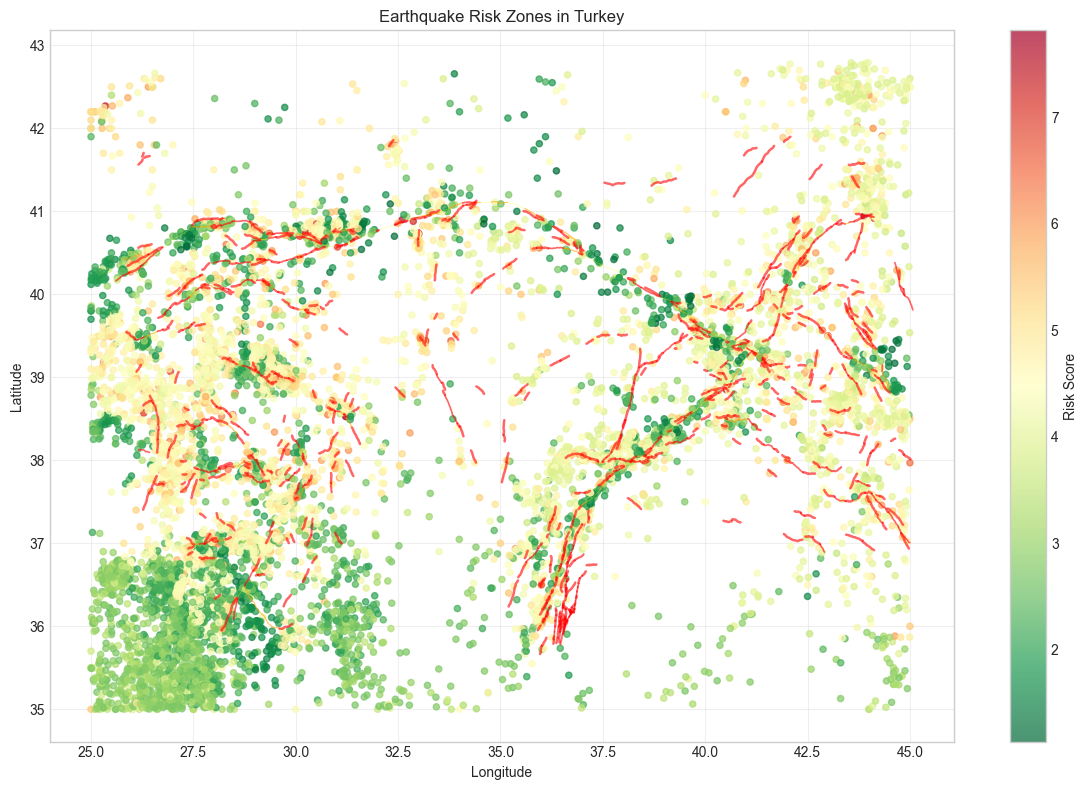

Unsupervised learning analysis completed!


In [228]:
# Save the clustering results
earthquake_df.to_csv('produced_data/earthquake_clusters.csv', index=False)

# Summarize cluster and risk zone characteristics
cluster_risk_summary = earthquake_df.groupby(['KMeans_Cluster', 'Risk_Zone']).agg({
    'Magnitude': ['mean', 'min', 'max', 'count'],
    'Depth': ['mean', 'min', 'max'],
    'Risk_Score': ['mean', 'min', 'max']
})

# Add fault information to summary if available
if 'distance_to_fault' in earthquake_df.columns:
    fault_summary = earthquake_df.groupby(['KMeans_Cluster', 'Risk_Zone']).agg({
        'distance_to_fault': ['mean', 'min'],
        'nearest_fault_importance': ['mean', 'max']
    })
    
    # Combine summaries
    cluster_risk_summary = pd.concat([cluster_risk_summary, fault_summary], axis=1)

print("Cluster and Risk Zone Summary:")
print(cluster_risk_summary)

# Final visualization: Risk zones by longitude/latitude
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    earthquake_df['Longitude'],  # X-axis is Longitude
    earthquake_df['Latitude'],   # Y-axis is Latitude
    c=earthquake_df['Risk_Score'],
    cmap='RdYlGn_r',  # Red for high risk, green for low risk
    alpha=0.7,
    s=20
)
plt.colorbar(scatter, label='Risk Score')
plt.title('Earthquake Risk Zones in Turkey')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# Add fault lines to plot if available
if 'fault_gdf' in locals():
    for _, fault in fault_gdf.iterrows():
        xs, ys = fault.geometry.xy
        importance = fault.get('importance', 1)
        color = 'red' if importance >= 4 else 'orange' if importance >= 3 else 'yellow'
        plt.plot(xs, ys, color=color, linewidth=importance*0.3, alpha=0.6)

plt.tight_layout()
plt.savefig('maps/earthquake_risk_zones.png', dpi=300)
plt.show()

print("Unsupervised learning analysis completed!")